# Reconstructing The Stochastic Gates Research
---
### Geometry of Information Course - Milestone #2 

**Made by**:<br>
[Aviv Gelfand](https://www.linkedin.com/in/aviv-gelfand/v) <br>
[Jonathan Wiesenfeld](https://il.linkedin.com/in/jonathan-wiesenfeld)

**Lectured by:** [Prof. Ariel Jaffe](https://arieljaffe.huji.ac.il/) 


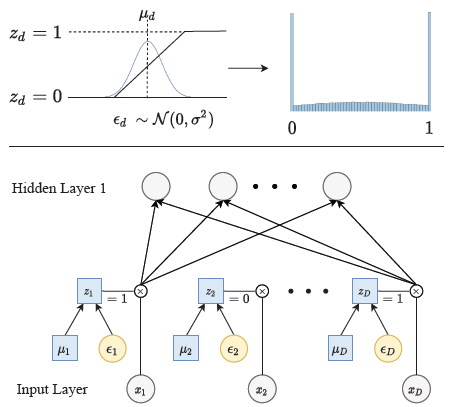
---

In this notebook, we apply the Stochastic Gates (STG) algorithm to both simulated and imported datasets to evaluate its efficacy in feature selection, through regression and classification tasks.

### Installing dependencies

In [5]:
# %pip install scikit-learn
# %pip install pandas
# %pip install seaborn
# %pip install torch
# %pip install stg 
# %pip install matplotlibv

# Regression and `sin_dataset`

We employ the STG algorithm, configured for regression tasks, with a neural network architecture comprising hidden layers with dimensions [500, 50, 10] and tanh activation. The model utilizes SGD optimization, a learning rate of 0.1, and feature selection enabled to discern the most relevant features influencing the regression outcome. The training process involves 3000 epochs with validation on a subset to monitor performance and prevent overfitting.

In [1]:
from stg import STG
import numpy as np
import torch
import scipy.stats # for creating a simple dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
### Helper function to save and compare regression metrics 

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import pandas as pd


## Sin_Dataset

The dataset comprises two input features, 'x1' and 'x2', and one output feature 'y'. 'x1' and 'x2' are random values between 1 and 5. 'y' is calculated as the sine of 'x1' multiplied by the cube of the cosine of 'x2'. Additional noise, sampled from a normal distribution with mean 0 and standard deviation 1, is added to the dataset, resulting in 'n' rows and 'p' columns. The first two columns represent 'x1' and 'x2', while the remaining columns contain noise variables.

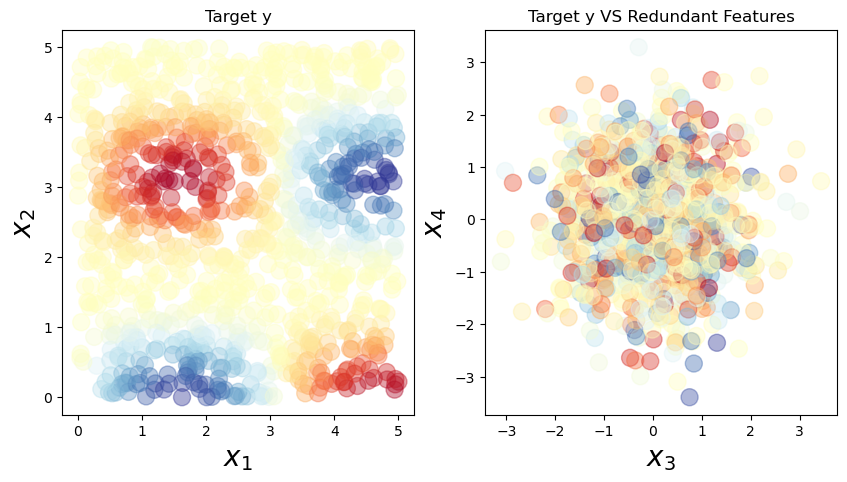

In [11]:
import warnings
warnings.filterwarnings('ignore')
from stg import STG
import numpy as np
import torch
import scipy.stats # for creating a simple dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# Create a simple dataset
def create_sin_dataset(n,p):
    x1=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    x2=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    y=np.sin(x1)*np.cos(x2)**3
    relevant=np.hstack((x1,x2))
    noise_vector = scipy.stats.norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y.astype(np.float32)

n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_sin_dataset(n_size,p_size)
# print(X_data.shape)
# print(y_data.shape)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 2], y=X_data[:, 3], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_3$', fontsize=20)
ax[1].set_ylabel('$x_4$', fontsize=20)
ax[1].set_title('Target y VS Redundant Features')
plt.tick_params(labelsize=10)


It can be observed that the target y is a non-linear function of the $X_1$ and $X_2$ features only.

Visual representation of the target variable y and the model's regression output on the synthetic dataset highlights the model's predictive accuracy and the non-linear relationship captured between the selected features and the target variable. This approach not only demonstrates the STG algorithm's potential in handling complex, noisy data but also its capability in feature selection and enhancing model interoperability.

Epoch: 1000: loss=0.113816 valid_loss=0.047806
Epoch: 2000: loss=0.064148 valid_loss=0.019180
Epoch: 3000: loss=0.038663 valid_loss=0.009584


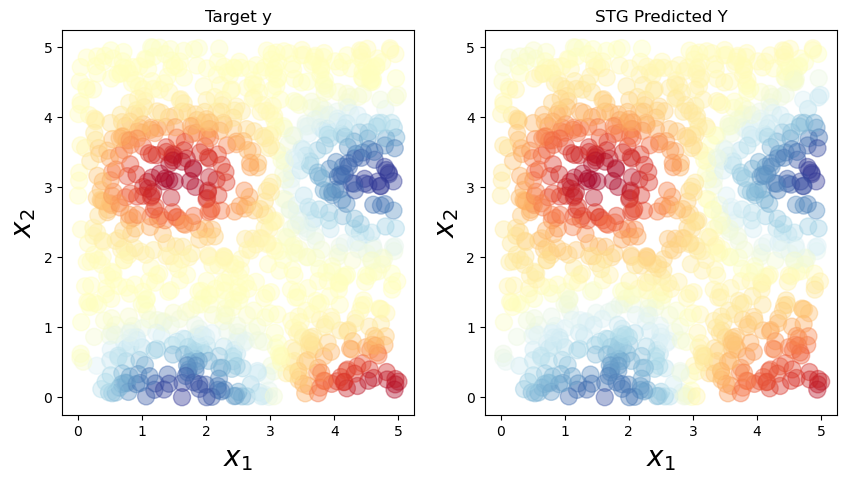

In [12]:
import warnings
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, random_state=42)


args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True
model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)

model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)

import torch
tmp_loss = torch.nn.MSELoss()
tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

tmp_loss(torch.Tensor(y_test), torch.Tensor(model.predict(X_test)))

model.get_gates(mode='prob')

model.get_gates(mode='raw')


## TESTING THE MODEL

y_pred=model.predict(X_data)
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_1$', fontsize=20)
ax[1].set_ylabel('$x_2$', fontsize=20)
ax[1].set_title('STG Predicted Y')
plt.tick_params(labelsize=10)
plt.show()


In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

p_size_ls = [3,4,5, 10, 20,50]
rmse_arr = []
sin_results_df = None
for p in p_size_ls:
    print(f"p={p}")
    n_size = 1000  # Number of samples
    X_data, y_data = create_sin_dataset(n_size, p)
    # Rest of the code from the previous cell
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8)

    args_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if args_cuda else "cpu")
    feature_selection = True
    model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)
    print("fitting model")
    model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)

    import torch
    tmp_loss = torch.nn.MSELoss()
    tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

    tmp_loss(torch.Tensor(y_test), torch.Tensor(model.predict(X_test)))

    # model.get_gates(mode='prob')

    # model.get_gates(mode='raw')

    ## TESTING THE MODEL
    y_pred=model.predict(X_test)
    rmse_arr.append(np.sqrt(np.mean((y_pred - y_test)**2)))
    if sin_results_df:
        sin_results_df = sin_results_df.append({
            'P_featuers': p,
            'gates_found': str(model.get_gates(mode='prob')),
            'R2 Score': r2_score(y_test, y_pred),
            'RMSE': mean_squared_error(y_test, y_pred, squared=False),
            'MAE': mean_absolute_error(y_test, y_pred),
            'MAPE': mean_absolute_percentage_error(y_test, y_pred)
        }, ignore_index=True)
    else:
        sin_results_df = pd.DataFrame({
        'P_featuers': p,
        'gates_found': str(model.get_gates(mode='prob')),
        'R2 Score': [r2_score(y_test, y_pred)],
        'RMSE': [mean_squared_error(y_test, y_pred, squared=False)],
        'MAE': [mean_absolute_error(y_test, y_pred)],
        'MAPE': [mean_absolute_percentage_error(y_test, y_pred)]
    })

sin_results_df

p=3
fitting model
Epoch: 1000: loss=0.160737 valid_loss=0.169206
Epoch: 2000: loss=0.158438 valid_loss=0.169214
Epoch: 3000: loss=0.158065 valid_loss=0.169222
p=4
fitting model
Epoch: 1000: loss=0.160014 valid_loss=0.177537
Epoch: 2000: loss=0.152662 valid_loss=0.177480


As shown in the above plot, the model successfully managed predict the correct output.

## Predicting Song Popularity 

In this task, we will use a sample of 150K records, out of the "Spotify Dataset 1921-2020, 600k+ Tracks.

### Columns:
* `popularity` - **Target Column** (Ranges from 0 to 100), float, representing the popularity of the song in the Spotify platform.
* `id` (Id of tracks generated by Spotify)
* `acousticness` (Ranges from 0 to 1)
* `danceability` (Ranges from 0 to 1)
* `energy` (Ranges from 0 to 1)
* `duration_ms` (Integer typically ranging from 200k to 300k)
* `instrumentalness` (Ranges from 0 to 1)
* `valence` (Ranges from 0 to 1)
* `animality` (Ranges from 0 to 1)
* `tempo` (Float typically ranging from 50 to 150)
* `liveness` (Ranges from 0 to 1)
* `loudness` (Float typically ranging from -60 to 0)
* `speechiness` (Ranges from 0 to 1)
* `release_year` a column which we are going to extract out of the Release column and predict based on song's features.
* `explicit` (Whether the song is explicit (contains swearing or inappropriate language) or not)
The following categorical columns will be removed to simplify the task (to many categories):



In [48]:
import pandas as pd
reg_url = 'https://raw.githubusercontent.com/FreeDataSets/DataPool/main/tracks_150000.csv' # this is the url for the dataset
reg_df = pd.read_csv(reg_url)#.sample(100000,random_state=42) # In order to reduce the size of the dataset, we are taking a random sample of 5000 rows from the dataset
reg_df.drop(['name', 'artists','id','release_date', 'artists_id','genre',], axis=1, inplace=True, errors='ignore') # Removing Categorical features with more then 10 unique values

# a preview of the dataframe
reg_df.info() 
display(reg_df.head())

# split the data into features and target variable 
Xreg = reg_df.drop('popularity', axis=1).values # features
yreg = reg_df['popularity'] # target variable

from sklearn.model_selection import train_test_split
# split the data into train and test sets
Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(Xreg, yreg, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler_reg = StandardScaler().fit(Xreg_train)
Xreg_train_scaled = scaler_reg.transform(Xreg_train)
Xreg_test_scaled = scaler_reg.transform(Xreg_test)


# Define model parameters
args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True

# Initialize and fit the model
model = STG(task_type='classification',input_dim=X_train.shape[1],output_dim=2,hidden_dims=[500, 50, 10],activation='tanh',optimizer='SGD',learning_rate=0.1,batch_size=32,
            feature_selection=feature_selection,sigma=0.5,lam=0.1,random_state=1,device=device)

model.fit( X_train, y_train, nr_epochs=3000, valid_X=X_test, valid_y=y_test, print_interval=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        150000 non-null  int64  
 1   duration_ms       150000 non-null  int64  
 2   explicit          150000 non-null  int64  
 3   danceability      150000 non-null  float64
 4   energy            150000 non-null  float64
 5   key               150000 non-null  int64  
 6   loudness          150000 non-null  float64
 7   speechiness       150000 non-null  float64
 8   acousticness      150000 non-null  float64
 9   instrumentalness  150000 non-null  float64
 10  liveness          150000 non-null  float64
 11  valence           150000 non-null  float64
 12  tempo             150000 non-null  float64
 13  time_signature    150000 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 16.0 MB


# Classification

## UCI Madelon Dataset 

MADELON is an artificial dataset, which was part of the NIPS 2003 feature selection challenge. This is a two-class classification problem with continuous input variables. The difficulty is that the problem is multivariate and highly non-linear.

In [64]:
%%capture

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
madelon = pd.read_csv('madelon.csv')

# Split the data into features and target
X = madelon.drop('Class', axis=1).values
y = madelon['Class'].values

# Convert labels from 1, 2 to 0, 1 for PyTorch compatibility
y = y - 1

# Ensure there are no invalid (e.g., negative) values
if np.any(y < 0):
    print("Found unexpected negative values in the target variable.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model parameters
args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True


metrics_dict = {'P_features':[],'accuracy': [],'f1':[], 'precision': [], 'recall': [], 'tp': [], 'tn': [], 'fp': [], 'fn': []}

k_values = [10, 100, 200, 500]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
import pandas as pd
for k in k_values:
    # Select the k first columns of the model
    X_train_k = X_train[:, :k]
    X_test_k = X_test[:, :k]
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit on the training data
    scaler.fit(X_train)

    # Transform both the training and testing data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Initialize and fit the model
    model = STG(task_type='classification',input_dim=X_train_k.shape[1],output_dim=2,hidden_dims=[500, 50, 10],activation='tanh',optimizer='SGD',learning_rate=0.1,batch_size=32,feature_selection=feature_selection,sigma=0.5,lam=0.1,random_state=1,device=device)
    # Fit the model
    model.fit(X_train_k, y_train, nr_epochs=100, valid_X=X_test_k, valid_y=y_test, print_interval=1000)

    # Create test predictions
    y_pred_k = model.predict(X_test_k)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred_k)
    # Extract the values from the confusion matrix
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    # Add metrics to metrics_dict
    metrics_dict['P_features'].append(k)
    metrics_dict['accuracy'].append(accuracy_score(y_test, y_pred_k))
    metrics_dict['f1'].append(f1_score(y_test, y_pred_k))
    metrics_dict['precision'].append(precision_score(y_test, y_pred_k))
    metrics_dict['recall'].append(recall_score(y_test, y_pred_k))
    # Append the values to the metrics_dict
    metrics_dict['tp'].append(tp)
    metrics_dict['tn'].append(tn)
    metrics_dict['fp'].append(fp)
    metrics_dict['fn'].append(fn)

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('P_features', inplace=True)
metrics_df

## Two Moons Data Set


p=5
Epoch: 1000: loss=0.334037 valid_loss=0.278322
Epoch: 2000: loss=0.113076 valid_loss=0.038264
Epoch: 3000: loss=0.088658 valid_loss=0.011227
Epoch: 4000: loss=0.085595 valid_loss=0.009120
Epoch: 5000: loss=0.084308 valid_loss=0.008783
Epoch: 6000: loss=0.070391 valid_loss=0.012212
<class 'tuple'> <class 'tuple'>
(1000,)
plotting results


C:\Users\yonat\AppData\Local\Temp\ipykernel_32924\1611040750.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
C:\Users\yonat\AppData\Local\Temp\ipykernel_32924\1611040750.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )


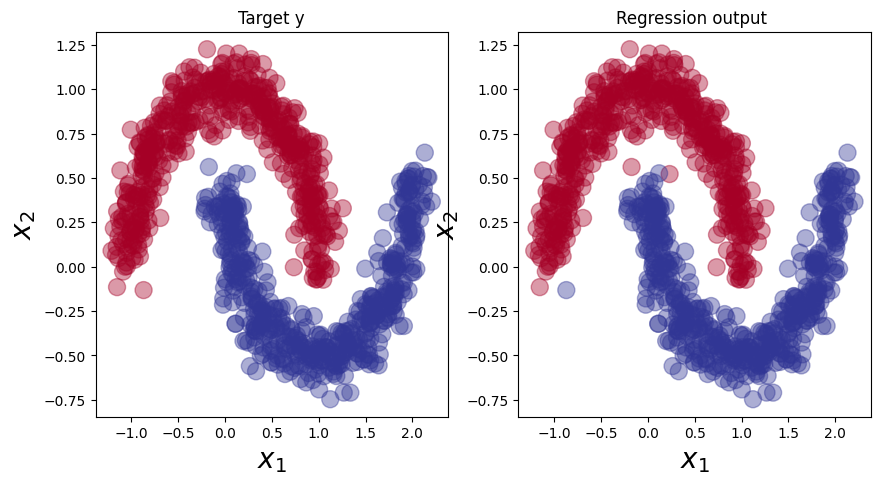

p=10
Epoch: 1000: loss=0.319043 valid_loss=0.348979
Epoch: 2000: loss=0.203970 valid_loss=0.151038
Epoch: 3000: loss=0.136947 valid_loss=0.017448
Epoch: 4000: loss=0.134029 valid_loss=0.016349
Epoch: 5000: loss=0.133177 valid_loss=0.015906
Epoch: 6000: loss=0.126025 valid_loss=0.008534
<class 'tuple'> <class 'tuple'>
(1000,)
plotting results


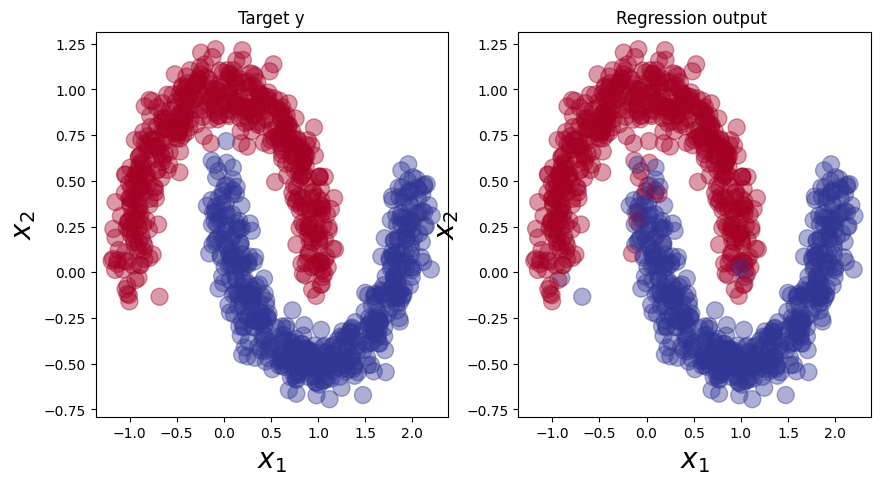

p=20
Epoch: 1000: loss=0.252780 valid_loss=0.489537
Epoch: 2000: loss=0.170828 valid_loss=0.923419
Epoch: 3000: loss=0.143170 valid_loss=1.040938
Epoch: 4000: loss=0.135173 valid_loss=0.885389
Epoch: 5000: loss=0.133502 valid_loss=0.698098
Epoch: 6000: loss=0.132799 valid_loss=0.577679
<class 'tuple'> <class 'tuple'>
(1000,)
plotting results


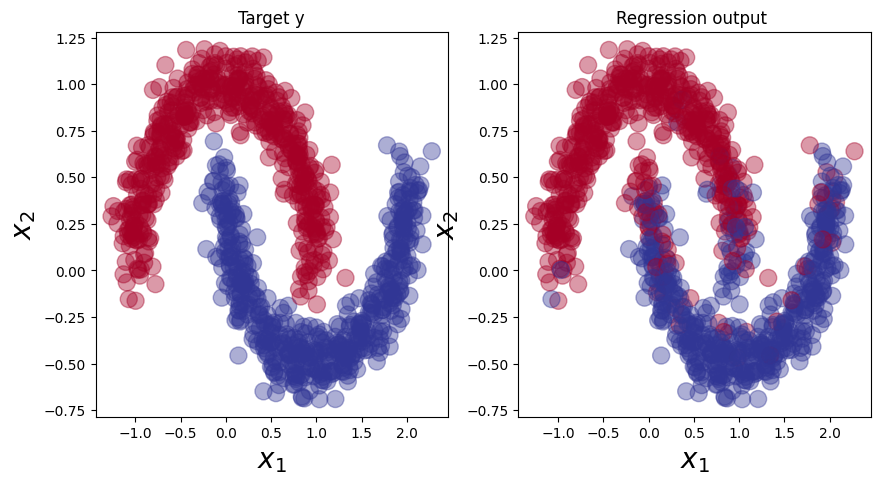

p=100
Epoch: 1000: loss=0.216964 valid_loss=0.326846
Epoch: 2000: loss=0.094828 valid_loss=0.069063
Epoch: 3000: loss=0.086695 valid_loss=0.047937
Epoch: 4000: loss=0.084786 valid_loss=0.047689
Epoch: 5000: loss=0.084146 valid_loss=0.045655
Epoch: 6000: loss=0.083991 valid_loss=0.040711
<class 'tuple'> <class 'tuple'>
(1000,)
plotting results


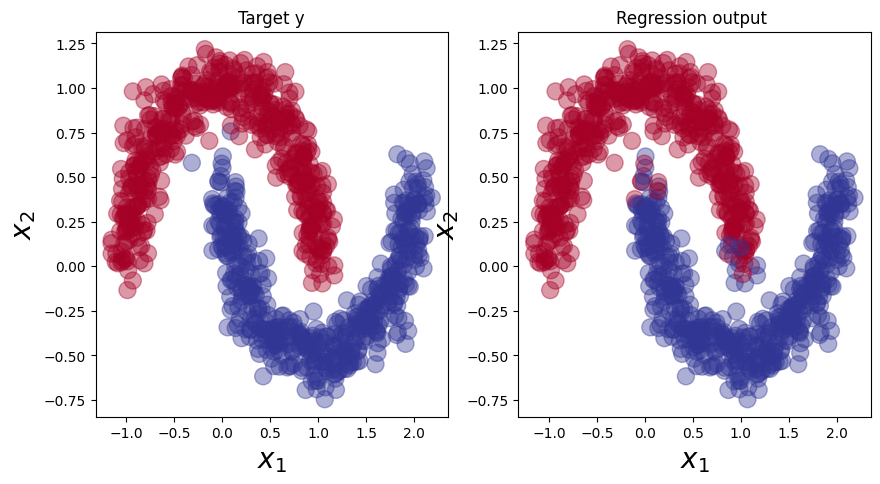

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[ 1.7189956   1.5118222  -1.6172392  -1.6172171  -1.6143297  -1.6165662
 -1.6152312  -1.612254   -1.6154304  -1.6135664  -1.6165012  -1.6165118
 -1.6135901  -1.6152109  -1.6169083   0.99067026 -1.6160054  -1.6088071
 -1.6170814  -1.6167477 ]


In [20]:
from stg import STG
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import make_moons
import torch

import numpy as np
from scipy.stats import norm

# Create a simple dataset
def create_twomoon_dataset(n, p):
    relevant, y = make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
    noise_vector = norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y

n_size = 1000 # Number of samples
p_size_ls = [5, 10, 20, 100]
acc_arr = []

for p in p_size_ls:
    
    X_data, y_data=create_twomoon_dataset(n_size,p_size)

    print(f"p={p}")
    n_size = 1000  # Number of samples
    
    # X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.9)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

    args_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if args_cuda else "cpu")
    feature_selection = True
    model = STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.5, random_state=1, device=device) 

    model.fit(X_train, y_train, nr_epochs=6000, valid_X=X_valid, valid_y=y_valid, print_interval=1000)

    tmp_loss = torch.nn.MSELoss()
    tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

    model.get_gates(mode='prob')

    model.get_gates(mode='raw')


    ## TESTING THE MODEL

    y_pred=model.predict(X_data)
    print(type(y_pred.shape),type(y_data.shape))
    criterion = torch.nn.BCEWithLogitsLoss()  # For binary classification
    loss = criterion(torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32))

    # Calculate accuracy
    
    acc_arr.append(loss)
    print("plotting results")
    
    # f, ax = plt.subplots(1, 2, figsize=(10, 5))

    # ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
    # ax[0].set_xlabel('$x_1$', fontsize=20)
    # ax[0].set_ylabel('$x_2$', fontsize=20)
    # ax[0].set_title('Target y')
    # ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
    # ax[1].set_xlabel('$x_1$', fontsize=20)
    # ax[1].set_ylabel('$x_2$', fontsize=20)
    # ax[1].set_title('Regression output ')
    # plt.tick_params(labelsize=10)
    # plt.show();


args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu") 
feature_selection = True

print(model.get_gates(mode='prob'))

print(model.get_gates(mode='raw') )


C:\Users\yonat\AppData\Local\Temp\ipykernel_32924\3567333.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )


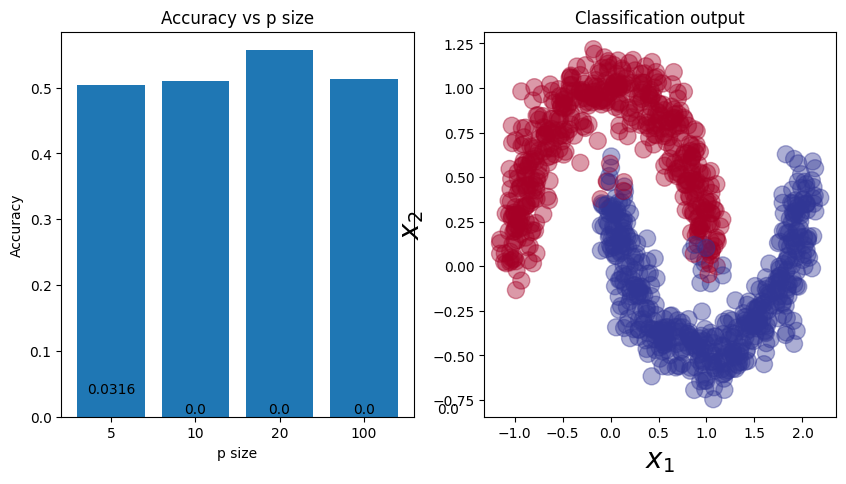

In [21]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].bar(range(len(p_size_ls)), acc_arr)
ax[0].set_xticks(range(len(p_size_ls)))
ax[0].set_xticklabels(p_size_ls)
ax[0].set_xlabel('p size')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs p size')

for i, v in enumerate(rmse_arr):
    ax[0].text(i, v, str(round(v, 4)), ha='center', va='upper' )
ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_1$', fontsize=20)
ax[1].set_ylabel('$x_2$', fontsize=20)
ax[1].set_title('Classification output')

plt.tick_params(labelsize=10)
plt.show()


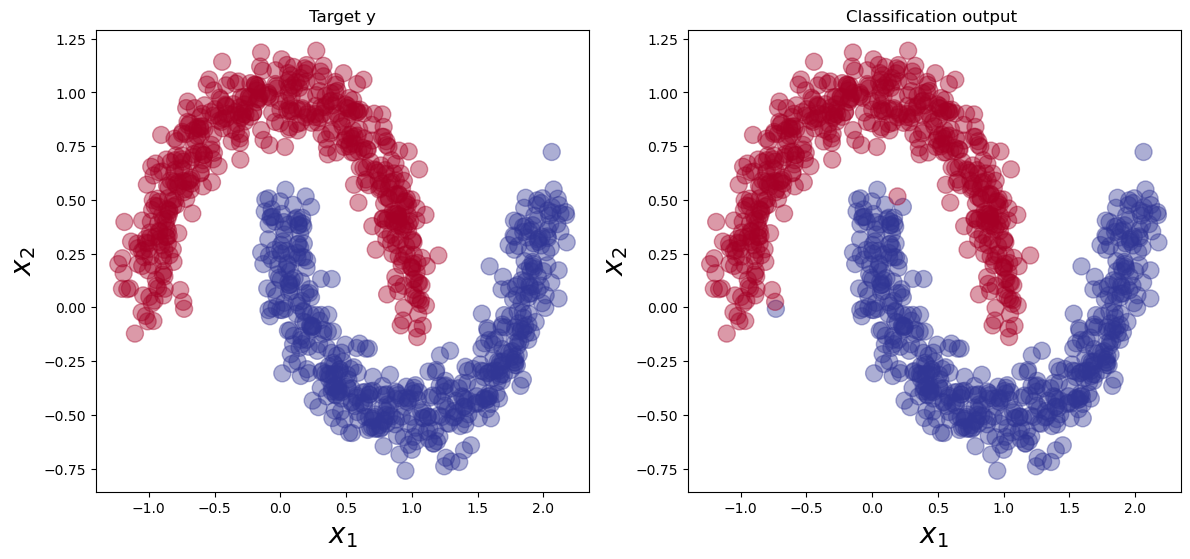

In [15]:
y_pred=model.predict(X_data)
import matplotlib.pyplot as plt
import matplotlib  # Make sure to import this

y_pred = model.predict(X_data)
f, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=matplotlib.colormaps['RdYlBu'])
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=matplotlib.colormaps['RdYlBu'])
ax[1].set_xlabel('$x_1$', fontsize=20)
ax[1].set_ylabel('$x_2$', fontsize=20)
ax[1].set_title('Classification output ')
plt.tick_params(labelsize=10)

### Confusion Matrix

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_data, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_data' is not defined

In [ ]:

conf_matrix_train = confusion_matrix(y_train_flat, y_pred_train_flat)
# conf_matrix_test = confusion_matrix(y_test_np, y_pred_test)

# Plot confusion matrix for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot confusion matrix for testing set
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

In [25]:
madelon.shape
X_data.shape

(1000, 20)

# Results

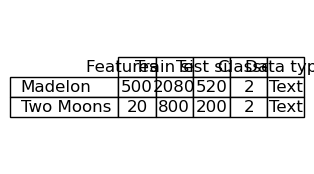

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Define the data for the table as a dictionary

# data only for madelon and "two moons" datasets

data = {
    'Features (D)': [500, 20],
    'Train size' : [2080, 800],
    'Test size' : [520, 200],   
    'Classes' : [2, 2],
    'Data type' : ['Text', 'Text']
}

df = pd.DataFrame(data, index=['Madelon', 'Two Moons'])

# Rendering the DataFrame as a matplotlib table
fig, ax = plt.subplots(figsize=(2, 2))  # set size frame
ax.axis('tight')
ax.axis('off')
the_table = table(ax, df, loc='center', cellLoc='center', colLoc='center')

# Apply font and alignment properties to the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2)

plt.show()
